# Proximity analysis
In this notebook we will be working with data from [OpenStreetMap](https://openstreetmap.org) to do proximity analysis to various urban amenities.

In [1]:
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource
from bokeh.plotting import figure
from bokeh.tile_providers import get_provider, STAMEN_TONER
import geopandas
import pyproj
from shapely.ops import transform
output_notebook()
%matplotlib inline

Loading BokehJS ...

## Import data

In [2]:
food_sources_file_name = "data/Tampere-food_sources.geojson"
building_footprints_file_name = "data/Tampere-buildings.gpkg"

In [3]:
food_sources = geopandas.read_file(food_sources_file_name)
buildings = geopandas.read_file(building_footprints_file_name)

## Use OSM for GeoDataFrame index

In [4]:
buildings.set_index("osm_id", inplace=True, verify_integrity=True)

In [5]:
food_sources.set_index("osm_id", inplace=True, verify_integrity=True)

In [6]:
buildings.shape

(16433, 5)

In [7]:
food_sources.head()

,fid,code,fclass,name,geometry
osm_id,,,,,
33403046,9,2511,convenience,K-Market Haapalinna,MULTIPOINT (2636757.686 8743361.457)
59359661,15,2501,supermarket,Nekalan Suurjako,MULTIPOINT (2647179.105 8736781.591)
257534920,69,2501,supermarket,Sale,MULTIPOINT (2645129.324 8737739.384)
269693256,74,2501,supermarket,S-market Pendoliino,MULTIPOINT (2646677.589 8741069.503)
442453872,121,2511,convenience,K-Market Kissanmaa,MULTIPOINT (2651590.496 8741284.592)


## Building centroids

In [8]:
buildings["centroid"] = buildings["geometry"].centroid

In [9]:
buildings.head()

,code,fclass,name,type,geometry,centroid
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


In [10]:
buildings.rename(
    columns={
        "geometry": "footprint",
        "centroid": "geometry"
    }, 
    inplace=True
)

In [11]:
buildings.head()

,code,fclass,name,type,footprint,geometry
osm_id,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055)
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709)
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620)
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543)
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104)


In [12]:
buildings.dtypes

code            int64
fclass         object
name           object
type           object
footprint    geometry
geometry     geometry
dtype: object

## Create buffers

In [13]:
one_km = 1000

food_sources_buffered = food_sources.buffer(one_km)

type(food_sources_buffered)

geopandas.geoseries.GeoSeries

## Dissolve buffers

In [14]:
food_sources_catchment = food_sources_buffered.unary_union
type(food_sources_catchment)

shapely.geometry.multipolygon.MultiPolygon

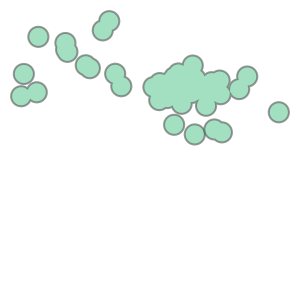

In [15]:
food_sources_catchment

## Buildings within food catchment

In [16]:
%%time
buildings["within_food_catchment"] = buildings.within(food_sources_catchment)

CPU times: user 9.34 s, sys: 161 ms, total: 9.5 s
Wall time: 9.64 s


In [17]:
buildings.head()

,code,fclass,name,type,footprint,geometry,within_food_catchment
osm_id,,,,,,,
4881423,1500,building,Tesoman liikekeskus,retail,"MULTIPOLYGON (((2630165.146 8743043.051, 26302...",POINT (2630225.788 8742972.055),True
4881551,1500,building,K-Market Winterinmutka,retail,"MULTIPOLYGON (((2634712.146 8743523.360, 26347...",POINT (2634757.358 8743507.709),False
4983894,1500,building,None,None,"MULTIPOLYGON (((2637171.795 8743326.127, 26371...",POINT (2637191.237 8743327.620),True
4983896,1500,building,None,None,"MULTIPOLYGON (((2637238.575 8743314.366, 26372...",POINT (2637257.370 8743316.543),True
4983916,1500,building,None,None,"MULTIPOLYGON (((2636996.066 8743546.463, 26370...",POINT (2637019.994 8743543.104),True


<AxesSubplot:>

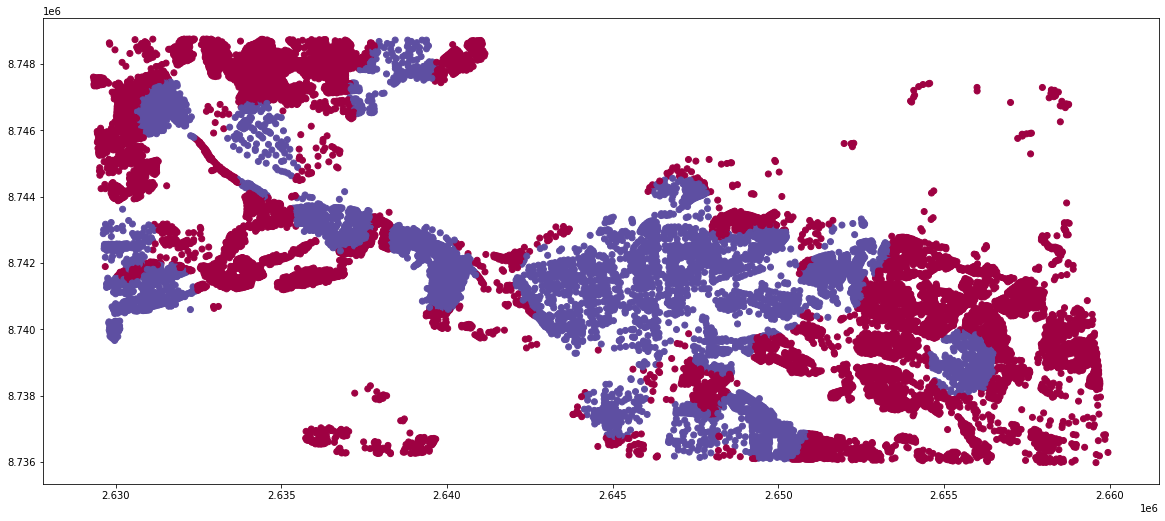

In [18]:
buildings.plot(categorical=True, column="within_food_catchment",figsize=(20, 15), cmap='Spectral')

## Bokeh test

In [19]:
food_sources_catchment_json = geopandas.GeoSeries([food_sources_catchment]).to_json()
buildings_json = buildings[["geometry", "within_food_catchment"]][:10].to_json()

In [20]:
geo_source = GeoJSONDataSource(geojson=buildings_json)

In [21]:
plot = figure(background_fill_color="lightgrey")

In [22]:
plot.circle(x='x', y='y', size=15, color='within_food_catchment', alpha=0.7, source=geo_source)

GlyphRenderer(id='1037', ...)

In [23]:
show(plot)